Link for this Notebook to avoid rendering in GitHub:https://colab.research.google.com/drive/1ueE1jtDV6JOrIYFWg99GMh1YP2IEVMpB?usp=sharing

In [1]:
import pandas as pd
df = pd.read_csv("df_final.csv")
df

review  rating
0      There is no real plot, and very little charact...     2.0
1      Volume 5 provided some of the answers to my un...     4.0
2      With the help of this book you will learn how ...     5.0
3      Took the youth group out for a fun night..defi...     1.0
4      Callie Hart is a friend, well in my mind she i...     5.0
...                                                  ...     ...
49995  We order from here once in a while, and we lik...     4.0
49996  3.5 StarsProphecy Girl is an intense read and ...     3.0
49997  Ceaseless is Abbi Glines conclusion to the Exi...     4.0
49998  I really enjoyed this book. The characters wer...     5.0
49999  multiple stories that have enough information ...     5.0

[50000 rows x 2 columns]

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
df["rating"].value_counts()

rating
5    28651
4    12874
3     4973
2     1942
1     1560
Name: count, dtype: int64

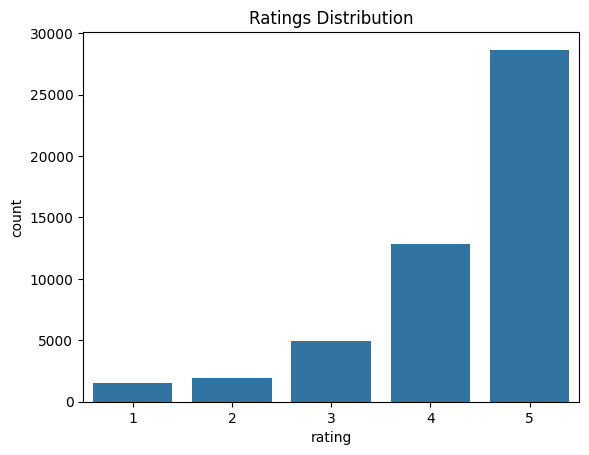

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

df["rating"] = df["rating"].astype(int)

sns.countplot(x="rating", data=df, order=[1,2,3,4,5])
plt.title("Ratings Distribution")
plt.show()


Exploratory Data Analysis and Data Preprocessing

In [7]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 17.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=a642d06ef8017c434192de0a4998e5747163bd23f20fd7e8eabc96dab1005b9e
  Stored in directory: /root/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect


In [8]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import langdetect
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm

# Download resources once
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

drop duplicates

In [9]:
# Drop exact duplicate rows
df = df.drop_duplicates(subset=["review", "rating"])

# Drop rows with missing reviews/ratings
df = df.dropna(subset=["review", "rating"])

print("After cleaning:", df.shape)

After cleaning: (49997, 2)


Text cleaning

In [10]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()  # lowercase
    text = re.sub(r"http\S+", "", text)  # remove links
    text = re.sub(r"[^a-z\s]", "", text)  # keep only letters
    text = re.sub(r"\s+", " ", text).strip()  # remove extra spaces
    return text

df["cleaned"] = df["review"].apply(clean_text)


Keeping only English language

In [11]:
def detect_lang(text):
    try:
        return langdetect.detect(text)
    except:
        return "unknown"

df["lang"] = df["cleaned"].apply(detect_lang)

# Keep only English reviews
df = df[df["lang"] == "en"]
df.shape

(49950, 4)

Lemmatizing

In [12]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    words = nltk.word_tokenize(text)
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

tqdm.pandas()  # progress bar
df["final_text"] = df["cleaned"].progress_apply(preprocess)


100%|██████████| 49950/49950 [00:29<00:00, 1682.96it/s]


Review Length Frequency

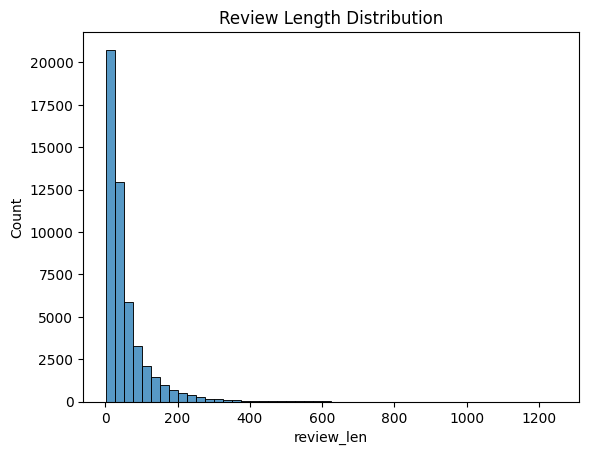

In [13]:
df["review_len"] = df["final_text"].apply(lambda x: len(x.split()))

sns.histplot(df["review_len"], bins=50)
plt.title("Review Length Distribution")
plt.show()

Average review length by rating

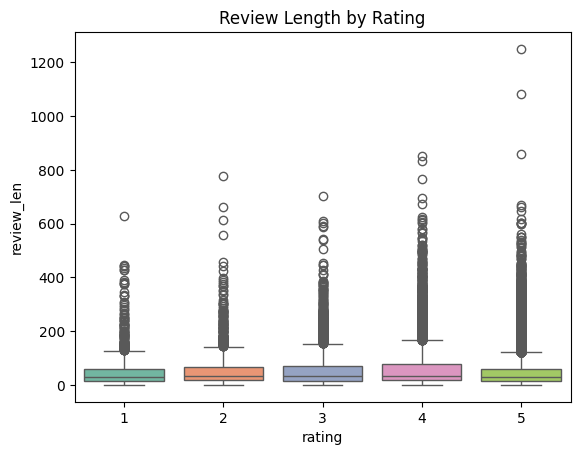

In [14]:
sns.boxplot(x="rating", y="review_len", data=df, palette="Set2")
plt.title("Review Length by Rating")
plt.show()


word cloud

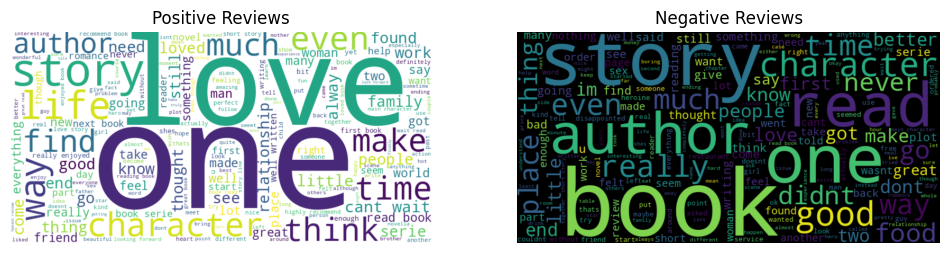

In [24]:
from wordcloud import WordCloud

pos_text = " ".join(df[df["rating"] >= 4]["final_text"])
neg_text = " ".join(df[df["rating"] <= 2]["final_text"])

wc_pos = WordCloud(width=800, height=400, background_color="white").generate(pos_text)
wc_neg = WordCloud(width=800, height=400, background_color="black").generate(neg_text)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(wc_pos, interpolation="bilinear")
plt.title("Positive Reviews")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(wc_neg, interpolation="bilinear")
plt.title("Negative Reviews")
plt.axis("off")
plt.show()

Top words by Rating

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

def top_words(class_df, n=15):
    vec = CountVectorizer(stop_words="english").fit(class_df)
    bag = vec.transform(class_df)
    sum_words = bag.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    return sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]

top_words_1_star = top_words(df[df["rating"]==1]["final_text"])
top_words_5_star = top_words(df[df["rating"]==5]["final_text"])

print("Top words in 1-star reviews:", top_words_1_star)
print("Top words in 5-star reviews:", top_words_5_star)

Top words in 1-star reviews: [('book', np.int64(1516)), ('like', np.int64(659)), ('story', np.int64(624)), ('read', np.int64(585)), ('time', np.int64(545)), ('didnt', np.int64(420)), ('author', np.int64(402)), ('dont', np.int64(400)), ('character', np.int64(396)), ('really', np.int64(365)), ('good', np.int64(363)), ('food', np.int64(333)), ('place', np.int64(269)), ('know', np.int64(263)), ('way', np.int64(263))]
Top words in 5-star reviews: [('book', np.int64(40154)), ('story', np.int64(19621)), ('read', np.int64(17974)), ('love', np.int64(14943)), ('great', np.int64(10169)), ('character', np.int64(10089)), ('series', np.int64(8669)), ('like', np.int64(8366)), ('really', np.int64(7913)), ('good', np.int64(7626)), ('author', np.int64(6932)), ('time', np.int64(6877)), ('loved', np.int64(6874)), ('life', np.int64(6106)), ('reading', np.int64(5861))]


In [15]:
df

review  rating  \
0      There is no real plot, and very little charact...       2   
1      Volume 5 provided some of the answers to my un...       4   
2      With the help of this book you will learn how ...       5   
3      Took the youth group out for a fun night..defi...       1   
4      Callie Hart is a friend, well in my mind she i...       5   
...                                                  ...     ...   
49995  We order from here once in a while, and we lik...       4   
49996  3.5 StarsProphecy Girl is an intense read and ...       3   
49997  Ceaseless is Abbi Glines conclusion to the Exi...       4   
49998  I really enjoyed this book. The characters wer...       5   
49999  multiple stories that have enough information ...       5   

                                                 cleaned lang  \
0      there is no real plot and very little characte...   en   
1      volume provided some of the answers to my unan...   en   
2      with the help of this book you will learn how ...   en   
3      took the youth group out for a fun nightdefini...   en   
4      callie hart is a friend well in my mind she is...   en   
...                                                  ...  ...   
49995  we order from here once in a while and we like...   en   
49996  starsprophecy girl is an intense read and i wa...   en   
49997  ceaseless is abbi glines conclusion to the exi...   en   
49998  i really enjoyed this book the characters were...   en   
49999  multiple stories that have enough information ...   en   

                                              final_text  review_len  
0      real plot little character development isnt re...          26  
1      volume provided answer unanswered question fir...          23  
2      help book learn make great delicious chocolate...          23  
3      took youth group fun nightdefinitely wont retu...          89  
4      callie hart friend well mind bestie cause like...         181  
...                                                  ...         ...  
49995  order like deliver quickly usually order greek...          45  
49996  starsprophecy girl intense read taken aback fi...         190  
49997  ceaseless abbi glines conclusion existence tri...         309  
49998  really enjoyed book character engaging story r...          18  
49999  multiple story enough information like charact...          11  

[49950 rows x 6 columns]

### Convert Ratings into Sentiment Labels for classification Task

In [16]:
def map_sentiment(r):
    if r <= 2:
        return "negative"
    elif r == 3:
        return "neutral"
    else:
        return "positive"

df["sentiment"] = df["rating"].apply(map_sentiment)
df["sentiment"].value_counts()


sentiment
positive    41479
neutral      4972
negative     3499
Name: count, dtype: int64

# Training and Testing Models using TF-IDF vectorization

First creating tfidf vectorization

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X = tfidf.fit_transform(df["final_text"])
y = df["sentiment"]


In [18]:
#imports
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score, classification_report,
    confusion_matrix, roc_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

In [19]:
# Encode labels numerically for ROC
from sklearn.preprocessing import LabelEncoder, label_binarize
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_bin = label_binarize(y_encoded, classes=np.unique(y_encoded))
n_classes = y_bin.shape[1]

In [20]:
# --- CV Setup ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [21]:
# --- Models ---
models = {
    "Logistic Regression": LogisticRegression(max_iter=200, n_jobs=-1),
    "Linear SVM": LinearSVC(),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=20, n_jobs=-1, random_state=42),
     "XGBoost": XGBClassifier(
    n_estimators=100,
    max_depth=6,
    tree_method='gpu_hist',  # Use GPU
    gpu_id=0,                # GPU device ID (usually 0)
    n_jobs=-1,
    random_state=42,
    eval_metric='logloss'
)
}

In [22]:
# --- Evaluation Function ---
def evaluate_model(model, X, y, cv, name):
    acc_scores, prec_scores, rec_scores, f1_scores, roc_scores = [], [], [], [], []

    for train_idx, test_idx in tqdm(cv.split(X, y), desc=f"{name} CV"):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc_scores.append(accuracy_score(y_test, y_pred))
        p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted")
        prec_scores.append(p)
        rec_scores.append(r)
        f1_scores.append(f1)

        # For ROC-AUC (only for models with predict_proba or decision_function)
        try:
            if hasattr(model, "predict_proba"):
                y_score = model.predict_proba(X_test)
            else:
                y_score = model.decision_function(X_test)

            roc = roc_auc_score(label_binarize(y_test, classes=np.unique(y)), y_score, average="macro", multi_class="ovr")
            roc_scores.append(roc)
        except:
            roc_scores.append(np.nan)

    return {
        "accuracy": np.mean(acc_scores),
        "precision": np.mean(prec_scores),
        "recall": np.mean(rec_scores),
        "f1": np.mean(f1_scores),
        "roc_auc": np.nanmean(roc_scores)
    }

In [23]:
# --- Run all models ---
results = {}
for name, model in models.items():
    results[name] = evaluate_model(model, X, y_encoded, cv, name)

Logistic Regression CV: 5it [00:14,  2.80s/it]
Linear SVM CV: 5it [00:06,  1.39s/it]
Random Forest CV: 5it [01:07, 13.56s/it]
XGBoost CV: 5it [00:19,  3.82s/it]


In [27]:
## ---Summary Table ---
results_df = pd.DataFrame(results).T
print(results_df)

                     accuracy  precision    recall        f1   roc_auc
Logistic Regression  0.871712   0.848177  0.871712  0.849064  0.906311
Linear SVM           0.867508   0.845656  0.867508  0.852530  0.877043
Random Forest        0.830450   0.717637  0.830450  0.753568  0.866059
XGBoost              0.550971   0.710559  0.550971  0.583181  0.507421


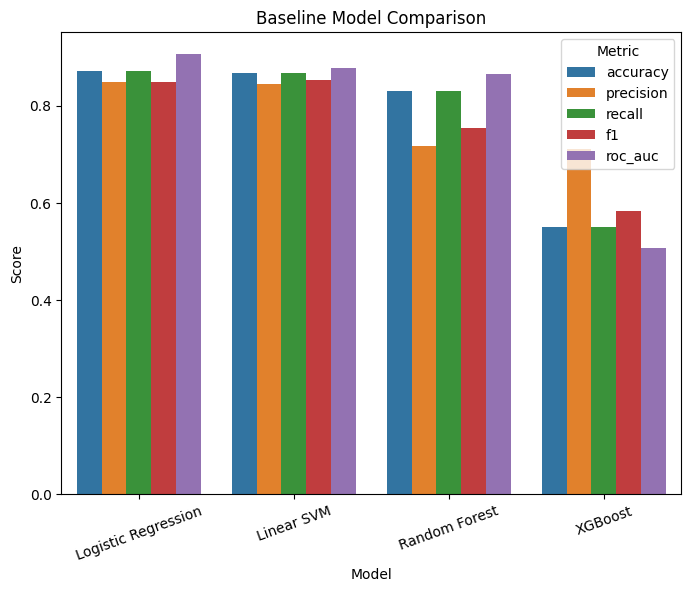

In [28]:
# --- Visualization ---
plt.figure(figsize=(8,6))
sns.barplot(data=results_df.reset_index().melt(id_vars="index"),
            x="index", y="value", hue="variable")
plt.title("Baseline Model Comparison")
plt.ylabel("Score")
plt.xlabel("Model")
plt.legend(title="Metric")
plt.xticks(rotation=20)
plt.show()

In [26]:
import joblib

# After CV evaluation, train each model on the full dataset and save
for name, model in models.items():
    print(f"Training and saving {name}...")
    model.fit(X, y_encoded)  # train on full data
    joblib.dump(model, f"{name.replace(' ', '_')}.pkl")  # save model
    print(f"Saved {name} as {name.replace(' ', '_')}.pkl")

Training and saving Logistic Regression...
Saved Logistic Regression as Logistic_Regression.pkl
Training and saving Linear SVM...
Saved Linear SVM as Linear_SVM.pkl
Training and saving Random Forest...
Saved Random Forest as Random_Forest.pkl
Training and saving XGBoost...
Saved XGBoost as XGBoost.pkl


#### Now Using	Fine-tune advanced models

##### Step 1: Prepare Data

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    df["final_text"], df["sentiment"],
    test_size=0.2, stratify=df["sentiment"], random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5, stratify=y_temp, random_state=42
)

print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))


Train size: 39960
Validation size: 4995
Test size: 4995


Step 1. Imports

In [30]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"          # Show real CUDA errors
os.environ["TOKENIZERS_PARALLELISM"] = "false"    # Avoid tokenizer warnings

##### Step 2: Encode Labels

In [31]:
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc   = label_encoder.transform(y_val)
y_test_enc  = label_encoder.transform(y_test)

num_labels = len(label_encoder.classes_)
print("Classes:", label_encoder.classes_)
print("num_labels:", num_labels)

Classes: ['negative' 'neutral' 'positive']
num_labels: 3


Step 3: Tokenization (DistilBERT)

In [32]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128)
val_encodings   = tokenizer(list(X_val), truncation=True, padding=True, max_length=128)
test_encodings  = tokenizer(list(X_test), truncation=True, padding=True, max_length=128)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

##### Step 4: Custom Dataset Class

In [33]:
class ReviewDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        return item

train_dataset = ReviewDataset(train_encodings, y_train_enc)
val_dataset   = ReviewDataset(val_encodings, y_val_enc)
test_dataset  = ReviewDataset(test_encodings, y_test_enc)
print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))

Train dataset size: 39960
Validation dataset size: 4995


In [34]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_enc),
    y=y_train_enc
)
class_weights = torch.tensor(class_weights, dtype=torch.float)
print("Class Weights:", class_weights)

Class Weights: tensor([4.7588, 3.3484, 0.4014])


##### Step : Weighted Trainer Definition

##### Class weights → weight minority classes higher in loss.

In [35]:
class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        #  Accept all future extra args via **kwargs
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


##### Step 5: Model + Training Setup

In [36]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,   # smaller batch to avoid GPU memory issues
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=True,
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    class_weights=class_weights,
)

# API - 743cd48208e03ce47b5afa4590da9ebcc2c197b1

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
trainer.train()  # API = 743cd48208e03ce47b5afa4590da9ebcc2c197b1

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: amansoni0908 (amansoni0908-self) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


TrainOutput(global_step=7494, training_loss=0.5893096851290847, metrics={'train_runtime': 1404.988, 'train_samples_per_second': 85.325, 'train_steps_per_second': 5.334, 'total_flos': 3970118737889280.0, 'train_loss': 0.5893096851290847, 'epoch': 3.0})

##### Step 6: Evaluation

In [38]:
preds = trainer.predict(test_dataset)
y_pred = np.argmax(preds.predictions, axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_test_enc, y_pred, target_names=label_encoder.classes_))


              precision    recall  f1-score   support

    negative       0.69      0.61      0.65       350
     neutral       0.36      0.58      0.44       497
    positive       0.95      0.89      0.92      4148

    accuracy                           0.84      4995
   macro avg       0.67      0.69      0.67      4995
weighted avg       0.87      0.84      0.85      4995



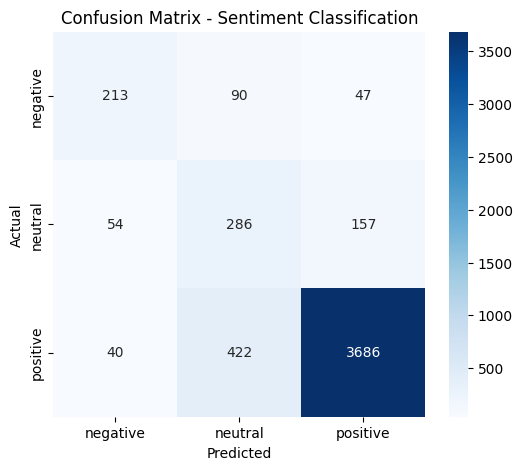

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_enc, y_pred)
labels = label_encoder.classes_

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Sentiment Classification")
plt.show()


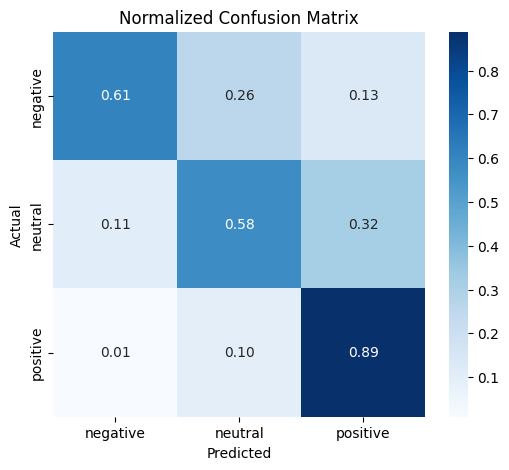

In [40]:

cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Normalized Confusion Matrix")
plt.show()


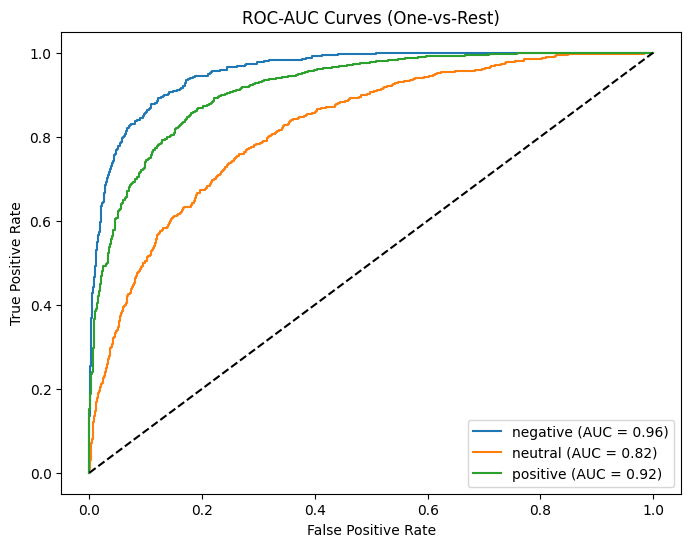

In [41]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

y_test_bin = label_binarize(y_test_enc, classes=np.arange(len(labels)))
y_score = preds.predictions  # shape [n_samples, n_classes]

plt.figure(figsize=(8,6))

for i, class_name in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC-AUC Curves (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


# Sentiment Analysis:

In [42]:
!pip install nltk textblob vaderSentiment spacy
!python -m textblob.download_corpora
!python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.9 MB/s eta 0:00:00
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 87.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_w

Imports

In [43]:
import pandas as pd
import nltk
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy

# Load spacy model for aspect extraction
nlp = spacy.load("en_core_web_sm")

# Ensure nltk data is downloaded
nltk.download('punkt')

#Initialize sentiment analyzers
# -----------------------------
vader = SentimentIntensityAnalyzer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Apply VADER & TextBlob

In [44]:

# -----------------------------
def get_vader_sentiment(text):
    score = vader.polarity_scores(str(text))['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

def get_textblob_sentiment(text):
    polarity = TextBlob(str(text)).sentiment.polarity
    if polarity > 0.05:
        return 'positive'
    elif polarity < -0.05:
        return 'negative'
    else:
        return 'neutral'

df['vader_sentiment'] = df['final_text'].apply(get_vader_sentiment)
df['textblob_sentiment'] = df['final_text'].apply(get_textblob_sentiment)

print("Added VADER and TextBlob sentiment columns")

Added VADER and TextBlob sentiment columns


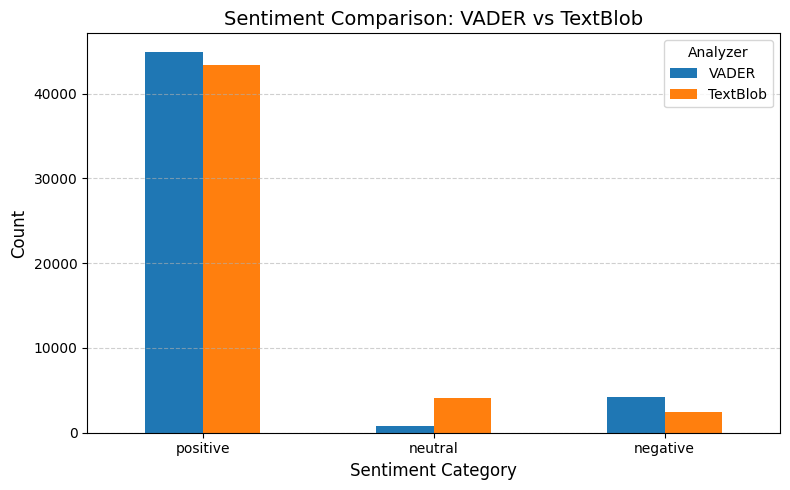

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count sentiments for both methods
vader_counts = df['vader_sentiment'].value_counts().reindex(['positive', 'neutral', 'negative'], fill_value=0)
textblob_counts = df['textblob_sentiment'].value_counts().reindex(['positive', 'neutral', 'negative'], fill_value=0)

# Combine into a DataFrame for plotting
sentiment_compare = pd.DataFrame({
    'VADER': vader_counts,
    'TextBlob': textblob_counts
})

# Plot grouped bar chart
sentiment_compare.plot(kind='bar', figsize=(8, 5))
plt.title('Sentiment Comparison: VADER vs TextBlob', fontsize=14)
plt.xlabel('Sentiment Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Analyzer')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### Aspect Based Sentiment Analysis:

Aspect Extraction (using spaCy)

Extract Nouns as the aspects for the sentiment. Later, we use these aspects for Topic modelling.

In [46]:

# -----------------------------
def extract_aspects(text):
    doc = nlp(str(text))
    # Extract nouns and noun chunks as potential aspects
    aspects = [chunk.text for chunk in doc.noun_chunks if len(chunk.text) > 1]
    return list(set(aspects))  # unique aspects per review

df['aspects'] = df['final_text'].apply(extract_aspects)
print("Extracted aspects (noun phrases) for each review")

Extracted aspects (noun phrases) for each review


Link aspects with sentiment

In [47]:

# -----------------------------
def aspect_sentiment_map(row):
    sentiment = row['vader_sentiment']
    return {aspect: sentiment for aspect in row['aspects']}


In [48]:
df['aspect_sentiment_map'] = df.apply(aspect_sentiment_map, axis=1)

In [49]:
df.to_csv("df_after_aspect.csv")

In [51]:
df.head()

review  rating  \
0  There is no real plot, and very little charact...       2   
1  Volume 5 provided some of the answers to my un...       4   
2  With the help of this book you will learn how ...       5   
3  Took the youth group out for a fun night..defi...       1   
4  Callie Hart is a friend, well in my mind she i...       5   

                                             cleaned lang  \
0  there is no real plot and very little characte...   en   
1  volume provided some of the answers to my unan...   en   
2  with the help of this book you will learn how ...   en   
3  took the youth group out for a fun nightdefini...   en   
4  callie hart is a friend well in my mind she is...   en   

                                          final_text  review_len sentiment  \
0  real plot little character development isnt re...          26  negative   
1  volume provided answer unanswered question fir...          23  positive   
2  help book learn make great delicious chocolate...          23  positive   
3  took youth group fun nightdefinitely wont retu...          89  negative   
4  callie hart friend well mind bestie cause like...         181  positive   

  vader_sentiment textblob_sentiment  \
0        positive           positive   
1         neutral           positive   
2        positive           positive   
3        negative           negative   
4        positive           positive   

                                             aspects  \
0  [ok substance story, usually ship, science fic...   
1  [volume, little disappointed v, four volume, s...   
2  [help book, helpful picture stephand crafted g...   
3  [minute, food, crazy bowl, fun town icing cake...   
4  [he, next book, amazing frigging story line, s...   

                                aspect_sentiment_map  
0  {'ok substance story': 'positive', 'usually sh...  
1  {'volume': 'neutral', 'little disappointed v':...  
2  {'help book': 'positive', 'helpful picture ste...  
3  {'minute': 'negative', 'food': 'negative', 'cr...  
4  {'he': 'positive', 'next book': 'positive', 'a...

In [52]:
df = df.drop(['review', 'cleaned' ], axis=1)
df.columns

Index(['rating', 'lang', 'final_text', 'review_len', 'sentiment',
       'vader_sentiment', 'textblob_sentiment', 'aspects',
       'aspect_sentiment_map'],
      dtype='object')

In [53]:
df

rating lang                                         final_text  \
0           2   en  real plot little character development isnt re...   
1           4   en  volume provided answer unanswered question fir...   
2           5   en  help book learn make great delicious chocolate...   
3           1   en  took youth group fun nightdefinitely wont retu...   
4           5   en  callie hart friend well mind bestie cause like...   
...       ...  ...                                                ...   
49995       4   en  order like deliver quickly usually order greek...   
49996       3   en  starsprophecy girl intense read taken aback fi...   
49997       4   en  ceaseless abbi glines conclusion existence tri...   
49998       5   en  really enjoyed book character engaging story r...   
49999       5   en  multiple story enough information like charact...   

       review_len sentiment vader_sentiment textblob_sentiment  \
0              26  negative        positive           positive   
1              23  positive         neutral           positive   
2              23  positive        positive           positive   
3              89  negative        negative           negative   
4             181  positive        positive           positive   
...           ...       ...             ...                ...   
49995          45  positive        positive           positive   
49996         190   neutral        positive           positive   
49997         309  positive        positive           positive   
49998          18  positive        positive           positive   
49999          11  positive        positive            neutral   

                                                 aspects  \
0      [ok substance story, usually ship, science fic...   
1      [volume, little disappointed v, four volume, s...   
2      [help book, helpful picture stephand crafted g...   
3      [minute, food, crazy bowl, fun town icing cake...   
4      [he, next book, amazing frigging story line, s...   
...                                                  ...   
49995  [really delicious white pizza tomato feta chee...   
49996  [whole life, friend burden, tough character, c...   
49997  [pagan dank apartpagan chance fall love dank j...   
49998  [really enjoyed book character engaging story ...   
49999  [plot character multiple story, multiple story...   

                                    aspect_sentiment_map  
0      {'ok substance story': 'positive', 'usually sh...  
1      {'volume': 'neutral', 'little disappointed v':...  
2      {'help book': 'positive', 'helpful picture ste...  
3      {'minute': 'negative', 'food': 'negative', 'cr...  
4      {'he': 'positive', 'next book': 'positive', 'a...  
...                                                  ...  
49995  {'really delicious white pizza tomato feta che...  
49996  {'whole life': 'positive', 'friend burden': 'p...  
49997  {'pagan dank apartpagan chance fall love dank ...  
49998  {'really enjoyed book character engaging story...  
49999  {'plot character multiple story': 'positive', ...  

[49950 rows x 9 columns]

# DEFECT TOPIC MODELING

In [55]:
#!pip install --quiet sentence-transformers bertopic umap-learn hdbscan plotly scikit-learn

In [56]:
# Imports
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from google.colab import files

For Defect Detection, we will only consider negative reviews.

In [57]:

# Filter negative reviews
negative_df = df[df['vader_sentiment'] == 'negative'].copy()
negative_df = negative_df[negative_df['final_text'].notna()]
print(f" Number of negative reviews: {len(negative_df)}")

 Number of negative reviews: 4270


In [58]:

# LDA (Latent Dirichlet Allocation)

vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(negative_df['final_text'])
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(X)

print("\n LDA Topics:")
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx}: ", [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:][::-1]])



 LDA Topics:
Topic 0:  ['book', 'read', 'series', 'story', 'life', 'know', 'love', 'thing', 'character', 'time']
Topic 1:  ['story', 'book', 'character', 'read', 'life', 'good', 'time', 'way', 'know', 'author']
Topic 2:  ['book', 'read', 'story', 'character', 'like', 'author', 'really', 'didnt', 'dont', 'reading']
Topic 3:  ['time', 'food', 'service', 'place', 'got', 'order', 'told', 'minute', 'went', 'didnt']
Topic 4:  ['story', 'book', 'author', 'character', 'murder', 'really', 'read', 'people', 'world', 'short']
Topic 5:  ['time', 'year', 'place', 'pizza', 'day', 'story', 'like', 'people', 'good', 'family']
Topic 6:  ['book', 'story', 'really', 'author', 'character', 'doesnt', 'time', 'make', 'case', 'want']
Topic 7:  ['book', 'story', 'read', 'time', 'life', 'vampire', 'like', 'way', 'man', 'woman']
Topic 8:  ['life', 'story', 'know', 'read', 'want', 'year', 'pain', 'come', 'parent', 'little']
Topic 9:  ['story', 'book', 'life', 'character', 'read', 'make', 'love', 'way', 'want', 

In [60]:

# NMF (Non-negative Matrix Factorization)

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(negative_df['final_text'])
nmf = NMF(n_components=10, random_state=42)
nmf.fit(X_tfidf)

print("\n NMF Topics:")
for idx, topic in enumerate(nmf.components_):
    print(f"Topic {idx}: ", [tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:][::-1]])



 NMF Topics:
Topic 0:  ['life', 'make', 'people', 'thing', 'know', 'woman', 'want', 'man', 'way', 'year']
Topic 1:  ['book', 'reading', 'author', 'end', 'disappointed', 'star', 'started', 'im', 'finish', 'way']
Topic 2:  ['food', 'service', 'place', 'time', 'order', 'minute', 'got', 'ordered', 'worst', 'table']
Topic 3:  ['didnt', 'like', 'really', 'dont', 'care', 'know', 'think', 'say', 'going', 'wanted']
Topic 4:  ['wait', 'happens', 'great', 'know', 'come', 'love', 'hot', 'installment', 'want', 'end']
Topic 5:  ['series', 'disappointed', 'love', 'installment', 'rest', 'waiting', 'th', 'second', 'im', 'written']
Topic 6:  ['read', 'author', 'ive', 'time', 'great', 'say', 'havent', 'review', 'day', 'definitely']
Topic 7:  ['character', 'plot', 'main', 'development', 'writing', 'murder', 'author', 'time', 'little', 'developed']
Topic 8:  ['good', 'bad', 'wasnt', 'really', 'word', 'editing', 'guy', 'thing', 'wrong', 'little']
Topic 9:  ['story', 'short', 'end', 'little', 'author', 'lin

In [61]:

# Prepare aspect phrases
aspect_list = []
for aspects in negative_df['aspects']:
    if isinstance(aspects, list):
        for aspect in aspects:
            if isinstance(aspect, str) and len(aspect.split()) <= 4:
                aspect_list.append(aspect)

aspect_list = list(set(aspect_list))  # remove duplicates
print(f" Unique aspect phrases: {len(aspect_list)}")


# Generate sentence embeddings for BERTopic

model = SentenceTransformer('all-MiniLM-L6-v2')
aspect_embeddings = model.encode(aspect_list, show_progress_bar=True)

# -----------------------------
# BERTopic
# -----------------------------
topic_model = BERTopic(
    language="english",
    calculate_probabilities=True,
    min_topic_size=10,
    verbose=True
)
topics, probs = topic_model.fit_transform(aspect_list, aspect_embeddings)

# Top 10 topics
topic_info = topic_model.get_topic_info()
print("\n Top BERTopic defect topics:")
print(topic_info.head(10))

# View top terms for first 5 topics
for t in range(5):
    print(f"\nTopic {t}: {topic_model.get_topic(t)}")

# -----------------------------
# Map aspects back to reviews
# -----------------------------
def find_aspect_topic_map(aspects):
    topic_dict = {}
    if isinstance(aspects, list):
        for a in aspects:
            if a in aspect_list:
                idx = aspect_list.index(a)
                topic_dict[a] = topics[idx]
    return topic_dict

negative_df['aspect_topics'] = negative_df['aspects'].apply(find_aspect_topic_map)

# -----------------------------
# Save results
# -----------------------------
negative_df.to_csv("defect_topics.csv", index=False)

# Download the file automatically
files.download("defect_topics.csv")


 Unique aspect phrases: 27577


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/862 [00:00<?, ?it/s]

2025-10-20 03:22:22,411 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-10-20 03:23:31,007 - BERTopic - Dimensionality - Completed ✓
2025-10-20 03:23:31,010 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-10-20 03:32:23,267 - BERTopic - Cluster - Completed ✓
2025-10-20 03:32:23,287 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-10-20 03:32:23,879 - BERTopic - Representation - Completed ✓



 Top BERTopic defect topics:
   Topic  Count                                 Name  \
0     -1   9426             -1_book_story_novel_read   
1      0    265       0_murder_crime_killer_murderer   
2      1    212    1_author_favorite_indie_extensive   
3      2    199       2_story_nothing_thread_overall   
4      3    181  3_series_seriesi_seriesit_seriesthe   
5      4    157        4_olivia_jennifer_maria_mandy   
6      5    153               5_adult_age_girl_young   
7      6    137           6_ryan_bruce_guthrie_bobby   
8      7    136              7_town_city_small_texas   
9      8    136   8_character_secondary_likeable_set   

                                      Representation  \
0  [book, story, novel, read, character, life, re...   
1  [murder, crime, killer, murderer, serial, crim...   
2  [author, favorite, indie, extensive, published...   
3  [story, nothing, thread, overall, brilliant, c...   
4  [series, seriesi, seriesit, seriesthe, fantast...   
5  [olivia, jenni

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [62]:
topic_model.visualize_topics()

In [64]:
# Save to HTML
fig = topic_model.visualize_topics()
fig.write_html("bertopic_topics.html")

 DEFECT-FOCUSED SENTIMENT MAPPING

In [66]:
# ==========================
# DEFECT-FOCUSED SENTIMENT MAPPING
# ==========================

# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from google.colab import files
import plotly.io as pio
pio.renderers.default = 'colab'



# Load Week 6 results
df_week6 = negative_df

# Ensure sentiment is string type
df_week6['vader_sentiment'] = df_week6['vader_sentiment'].astype(str)

# Create a defect-focused sentiment mapping
def map_defect_sentiment(row):
    aspect_topics = eval(row['aspect_topics']) if isinstance(row['aspect_topics'], str) else row['aspect_topics']
    mapping = {}
    for aspect, topic in aspect_topics.items():
        mapping[aspect] = {'topic_id': topic, 'sentiment': row['vader_sentiment']}
    return mapping

df_week6['defect_sentiment_map'] = df_week6.apply(map_defect_sentiment, axis=1)

# Flatten defect-topic-sentiment mapping for analysis
records = []
for idx, row in df_week6.iterrows():
    for aspect, info in row['defect_sentiment_map'].items():
        records.append({
            'review_id': idx,
            'aspect': aspect,
            'topic_id': info['topic_id'],
            'sentiment': info['sentiment']
        })

df_defects = pd.DataFrame(records)
print(f"Total defect-aspect records: {len(df_defects)}")
df_defects.head(10)

# Aggregate defect sentiment counts per topic
topic_sentiment_counts = df_defects.groupby(['topic_id', 'sentiment']).size().unstack(fill_value=0)

# Ensure consistent sentiment columns for visualization
for col in ['negative', 'neutral', 'positive']:
    if col not in topic_sentiment_counts.columns:
        topic_sentiment_counts[col] = 0

print("\nDefect sentiment counts per topic:")
print(topic_sentiment_counts)

top10 = topic_sentiment_counts.head(10)

fig = px.bar(
    top10.reset_index(),
    x='topic_id',
    y=['negative', 'neutral', 'positive'],
    title='Sentiment Distribution per Defect Topic (Top 10)',
    labels={'value': 'Count', 'topic_id': 'Topic ID'},
    barmode='group'
)

fig.show()



# Save  results
df_defects.to_csv("defect_sentiment_mapping.csv", index=False)
files.download("defect_sentiment_mapping.csv")


Total defect-aspect records: 38241

Defect sentiment counts per topic:
sentiment  negative  neutral  positive
topic_id                              
-1            11527        0         0
 0              307        0         0
 1              400        0         0
 2              483        0         0
 3              278        0         0
...             ...      ...       ...
 575             13        0         0
 576             13        0         0
 577             10        0         0
 578             13        0         0
 579             18        0         0

[581 rows x 3 columns]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Topic Mapping

Manually assigning topic 5 topic names for better understanding of defects and flaws in that topic.

In [67]:
# Create a mapping dictionary
topic_map = {
    0: "General Fiction & Reading Experience",
    -1: "Crime / Serial-Killer Thriller",
    1: "Authors & Publishing",
    2: "Plot & Pacing / Narrative Quality",
    3: "Series & Fantasy Franchises"
}

# Replace numeric topic_id values with text labels
df_defects["topic_id"] = df_defects["topic_id"].map(topic_map)

# (Optional) verify
df_defects["topic_id"].value_counts()


df_defects

review_id                      aspect                        topic_id  \
0              3                      minute                             NaN   
1              3                        food                             NaN   
2              3                  crazy bowl  Crime / Serial-Killer Thriller   
3              3      everything gross table                             NaN   
4              3            everything place                             NaN   
...          ...                         ...                             ...   
38236      49986             ill read series                             NaN   
38237      49986  changed character one page                             NaN   
38238      49986                        next  Crime / Serial-Killer Thriller   
38239      49986            book h p mallory  Crime / Serial-Killer Thriller   
38240      49986            hanging addition                             NaN   

      sentiment  
0      negative  
1      negative  
2      negative  
3      negative  
4      negative  
...         ...  
38236  negative  
38237  negative  
38238  negative  
38239  negative  
38240  negative  

[38241 rows x 4 columns]

In [68]:
from collections import Counter
import pandas as pd

# Define a function to get top 5 words for each topic
def top_words_by_topic(df, text_col="aspect", group_col="topic_id", top_n=5):
    results = {}
    for topic, group in df.groupby(group_col):
        words = " ".join(group[text_col].astype(str)).lower().split()
        common = Counter(words).most_common(top_n)
        results[topic] = [word for word, _ in common]
    return pd.DataFrame.from_dict(results, orient="index", columns=[f"Top_{i+1}" for i in range(top_n)])

# Apply the function
top_words_df = top_words_by_topic(df_defects, text_col="aspect", group_col="topic_id", top_n=5)

# Display the result
print(top_words_df)


                                       Top_1  Top_2      Top_3     Top_4  \
Authors & Publishing                  author   book        one       job   
Crime / Serial-Killer Thriller          book  story  something       one   
General Fiction & Reading Experience  murder  crime     killer  murderer   
Plot & Pacing / Narrative Quality      story   good    nothing   overall   
Series & Fantasy Franchises           series    one      first      part   

                                        Top_5  
Authors & Publishing                     work  
Crime / Serial-Killer Thriller          thing  
General Fiction & Reading Experience  mystery  
Plot & Pacing / Narrative Quality         one  
Series & Fantasy Franchises            entire  


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                     author    book    one  job work  story  \
Authors & Publishing                  391.0    28.0    9.0  6.0  6.0          
Crime / Serial-Killer Thriller               1055.0  276.0            547.0   
Plot & Pacing / Narrative Quality                      7.0            475.0   
Series & Fantasy Franchises                           12.0                    
General Fiction & Reading Experience                                          

                                     something  thing murder crime killer  \
Authors & Publishing                                                        
Crime / Serial-Killer Thriller           297.0  272.0                       
Plot & Pacing / Narrative Quality                                           
Series & Fantasy Franchises                                                 
General Fiction & Reading Experience                   107.0  66.0   54.0   

                                     murderer mystery  good no

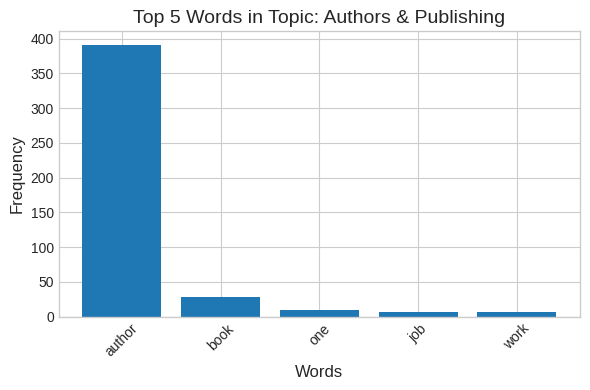

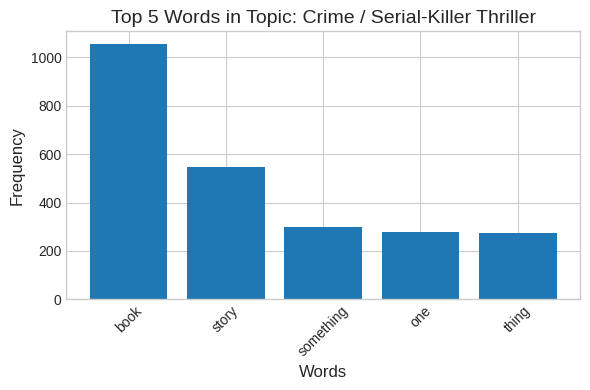

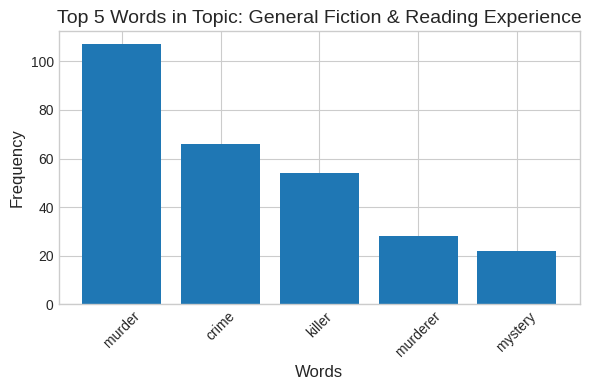

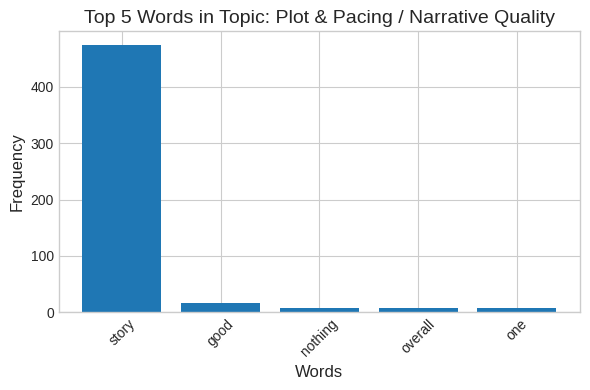

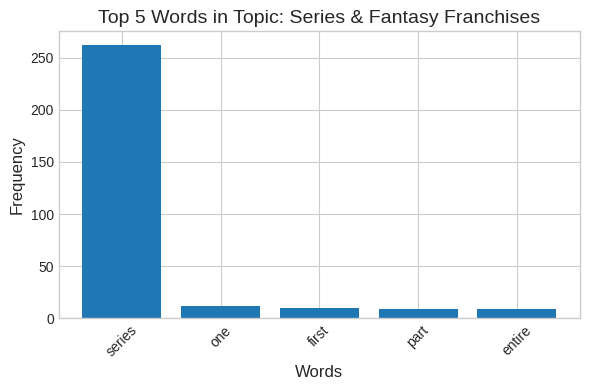

In [69]:
import nltk
nltk.download('stopwords')

import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords

# --- STEP 1: Clean text ---
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', str(text))  # remove punctuation/numbers
    return " ".join([w for w in text.lower().split() if w not in stop_words])

df_defects["clean_aspect"] = df_defects["aspect"].apply(clean_text)

# --- STEP 2: Function to get top N words per topic ---
def get_top_words(df, text_col="clean_aspect", group_col="topic_id", top_n=5):
    topic_word_counts = {}
    for topic, group in df.groupby(group_col):
        words = " ".join(group[text_col].astype(str)).split()
        common_words = Counter(words).most_common(top_n)
        topic_word_counts[topic] = dict(common_words)
    return topic_word_counts

top_words_dict = get_top_words(df_defects, top_n=5)

# --- STEP 3: Convert to DataFrame for viewing ---
top_words_df = (
    pd.DataFrame.from_dict(top_words_dict, orient="index")
    .fillna("")
)
print(top_words_df)

# --- STEP 4: Plot bar charts ---
plt.style.use("seaborn-v0_8-whitegrid")
for topic, word_counts in top_words_dict.items():
    words, counts = zip(*word_counts.items())
    plt.figure(figsize=(6, 4))
    plt.bar(words, counts)
    plt.title(f"Top {len(words)} Words in Topic: {topic}", fontsize=14)
    plt.xlabel("Words", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# FINAL REPORT & RESULTS DASHBOARD

Loaded Week 7 results — total records: 38241


review_id                  aspect                        topic_id  \
0          3                  minute                             NaN   
1          3                    food                             NaN   
2          3              crazy bowl  Crime / Serial-Killer Thriller   
3          3  everything gross table                             NaN   
4          3        everything place                             NaN   

  sentiment            clean_aspect  
0  negative                  minute  
1  negative                    food  
2  negative              crazy bowl  
3  negative  everything gross table  
4  negative        everything place

Metric  Value
0   Total Reviews Analyzed   4186
1     Total Unique Aspects  27577
2  Total Topics Identified      5

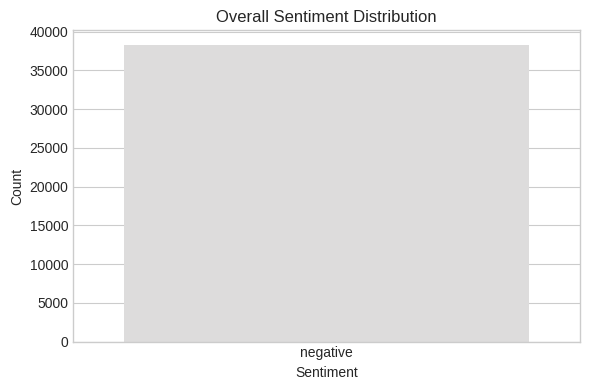

In [70]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
from IPython.display import display
from google.colab import files

pio.renderers.default = 'colab'

# Load Week 7 results
# df_week7 = pd.read_csv("week7_defect_sentiment_mapping.csv")

print(f"Loaded Week 7 results — total records: {len(df_defects)}")
display(df_defects.head())

# Basic dataset summary
summary = {
    "Total Reviews Analyzed": len(df_defects["review_id"].unique()),
    "Total Unique Aspects": df_defects["aspect"].nunique(),
    "Total Topics Identified": df_defects["topic_id"].nunique(),
}
summary_df = pd.DataFrame(list(summary.items()), columns=["Metric", "Value"])
display(summary_df)

# Sentiment distribution
sentiment_counts = df_defects["sentiment"].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="coolwarm")
plt.title("Overall Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("sentiment_distribution.png")
plt.show()

# Topic frequency visualization
topic_counts = df_defects["topic_id"].value_counts().reset_index()
topic_counts.columns = ["topic_id", "count"]
fig = px.bar(
    topic_counts,
    x="topic_id",
    y="count",
    title="Defect Topic Frequency",
    labels={"topic_id":"Topic ID", "count":"Number of Mentions"},
    color="count",
)
fig.write_html("defect_topic_frequency.html")
fig.show()

# Sentiment distribution per topic
topic_sentiment = df_defects.groupby(["topic_id", "sentiment"]).size().unstack(fill_value=0)
fig2 = px.bar(
    topic_sentiment.reset_index(),
    x="topic_id",
    y=["positive", "neutral", "negative"] if "positive" in topic_sentiment.columns else topic_sentiment.columns,
    title="Sentiment Distribution per Defect Topic",
    barmode="group"
)
fig2.write_html("sentiment_per_topic.html")
fig2.show()


In [75]:
# Download all important files

files.download("sentiment_distribution.png")
files.download("defect_topic_frequency.html")
files.download("sentiment_per_topic.html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# To avoid rendering in Github
import nbformat
nb = nbformat.read("defects_detection.ipynb", as_version =4)
nb.metadata.pop("widgets",None)
nbformat.write(nb,"defects_detection.ipynb")